In [37]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import os
import pandas as pd

import torch
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

from utils import Resize, RecognitionDataset, collate_fn, decode, train_model, load_checkpoint, get_predictions
from model import FeatureExtractor, SequencePredictor, CRNN

In [28]:
DATA_PATH = '../data_2/'
RESULTS_PATH = 'results/'
MODELS_PATH = 'models/'

TRAIN_IMAGES = os.path.join(DATA_PATH, 'train/train')
TEST_IMAGES = os.path.join(DATA_PATH, 'test/test')

SIZE_M = (320, 100)

In [5]:
if not os.path.exists(RESULTS_PATH):
    os.mkdir(RESULTS_PATH)
    
if not os.path.exists(MODELS_PATH):
    os.mkdir(MODELS_PATH)

### 1. Подготовим данные

In [6]:
train_data = pd.read_csv(os.path.join(DATA_PATH, 'train_labels.csv'))
train_data

,Id,Expected
0,1.jpg,Атырау
1,2.jpg,транз
2,3.jpg,ходят
3,4.jpg,"ощущений,"
4,5.jpg,74
...,...,...
275995,275996.jpg,DO
275996,275997.jpg,BASUCC
275997,275998.jpg,"1,120"
275998,275999.jpg,"наблюдателей,"


Пустыне значения Expected 27


<AxesSubplot:>

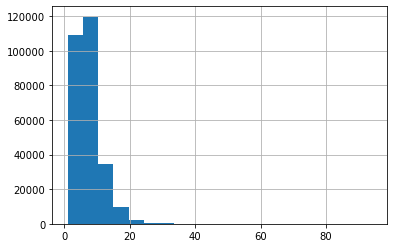

In [7]:
print('Пустыне значения Expected', len(train_data[train_data.Expected != train_data.Expected]))
train_data.Expected.str.len().hist(bins=20)

В датасете есть пропуски в Expected. Так же, основная часть текстов длиной не более 20 символов. Оставим только их + уберем пропуски.

In [8]:
train_data = train_data.dropna()
train_data = train_data[train_data.Expected.str.len() <= 20]

Сформируем наш "алфавит"

In [9]:
char_to_id = {}
char_counts = {}

char_id = 1
for i in tqdm(range(len(train_data))):
    label = train_data.iloc[i]['Expected']
    for char in label:
        if char not in char_to_id:
            char_to_id[char] = char_id
            char_counts[char] = 1
            char_id += 1
        else:
            char_counts[char] += 1
            

id_to_char = {id: char for char, id in char_to_id.items()}

print(f'Длина алфавита: {len(char_to_id)}')

  0%|          | 0/273475 [00:00<?, ?it/s]

Длина алфавита: 604


Алфавит кажется слишком длинным (изначально с таким у меня плохо обучалось). Посмотрим на него

In [10]:
sorted(char_counts.items(), key=lambda x:x[1])

[('山', 1),
 ('形', 1),
 ('法', 1),
 ('意', 1),
 ('好', 1),
 ('的', 1),
 ('時', 1),
 ('刻', 1),
 ('追', 1),
 ('分', 1),
 ('є', 1),
 ('Ë', 1),
 ('だ', 1),
 ('만', 1),
 ('복', 1),
 ('ป', 1),
 ('ร', 1),
 ('ส', 1),
 ('ท', 1),
 ('น', 1),
 ('鄧', 1),
 ('宗', 1),
 ('楊', 1),
 ('٬', 1),
 ('魚', 1),
 ('藍', 1),
 ('観', 1),
 ('音', 1),
 ('記', 1),
 ('ö', 1),
 ('♬', 1),
 ('հ', 1),
 ('ק', 1),
 ('נ', 1),
 ('ו', 1),
 ('ס', 1),
 ('ἰ', 1),
 ('χ', 1),
 ('θ', 1),
 ('村', 1),
 ('く', 1),
 ('ん', 1),
 ('ὶ', 1),
 ('▲', 1),
 ('Ù', 1),
 ('重', 1),
 ('،', 1),
 ('բ', 1),
 ('ց', 1),
 ('社', 1),
 ('會', 1),
 ('通', 1),
 ('詮', 1),
 ('ɑ', 1),
 ('☎', 1),
 ('Υ', 1),
 ('Ｏ', 1),
 ('ㄉ', 1),
 ('ㄞ', 1),
 ('後', 1),
 ('喫', 1),
 ('煙', 1),
 ('者', 1),
 ('和', 1),
 ('▁', 1),
 ('あ', 1),
 ('さ', 1),
 ('ひ', 1),
 ('江', 1),
 ('州', 1),
 ('δ', 1),
 ('と', 1),
 ('ば', 1),
 ('Ü', 1),
 ('ु', 1),
 ('ळ', 1),
 ('そ', 1),
 ('甲', 1),
 ('婓', 1),
 ('郎', 1),
 ('等', 1),
 ('兵', 1),
 ('き', 1),
 ('ょ', 1),
 ('Ք', 1),
 ('ի', 1),
 ('չ', 1),
 ('阪', 1),
 ('府', 1),
 ('Đ', 1),
 ('á', 1),

Посмотрев на алфавит, решил удалить из него все символы, количество встречаемости которых меньше 27.
Так же убираю из тренировочного набора все данные, в которых содержались удаленные символы.

In [11]:
good_letters = set([x[0] for x in char_counts.items() if x[1] >= 27])
print(f'Осталось символов в алфавите: {len(good_letters)}')


train_data = train_data[train_data.Expected.apply(
    lambda text: len(set(text).intersection(good_letters)) == len(set(text))
)].reset_index(drop=True)

print(f'Длина датасета в результате: {len(train_data)}')

char_to_id = {}
char_counts = {}

char_id = 1
for i in tqdm(range(len(train_data))):
    label = train_data.iloc[i]['Expected']
    for char in label:
        if char not in char_to_id:
            char_to_id[char] = char_id
            char_counts[char] = 1
            char_id += 1
        else:
            char_counts[char] += 1
            

id_to_char = {id: char for char, id in char_to_id.items()}

print(f'Длина алфавита в результате (для проверки): {len(char_to_id)}')

Осталось символов в алфавите: 183
Длина датасета в результате: 272900


  0%|          | 0/272900 [00:00<?, ?it/s]

Длина алфавита в результате (для проверки): 183


In [12]:
t_data = train_data.sample(frac=1, random_state=42)

train_size = int(len(t_data) * 0.9)
config_train = t_data[:train_size]
config_val = t_data[train_size:]

train_transform = Resize(size=SIZE_M)

train_dataset = RecognitionDataset(config_train, char_to_id=char_to_id, folder=TRAIN_IMAGES, 
                                   transforms=train_transform)
val_dataset = RecognitionDataset(config_val, char_to_id=char_to_id, folder=TRAIN_IMAGES,
                                 transforms=train_transform)

train_batch_size = 350
val_batch_size = 128
num_workers = 6

train_dataloader = DataLoader(train_dataset, 
                              batch_size=train_batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, 
                              drop_last=True, collate_fn=collate_fn)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=val_batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, 
                            drop_last=False, collate_fn=collate_fn)

### Обучение модели

In [13]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [32]:
checkpoint_name='models/model_1'
num_epochs = 100

crnn = CRNN(alphabet=char_to_id, cnn_input_size=SIZE_M[::-1], cnn_output_len=80,
            rnn_bidirectional=True, rnn_hidden_size=128, rnn_dropout=0.3)
crnn.to(device)

optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-3, amsgrad=True, weight_decay=1e-4)


train_model(device, crnn, optimizer, train_dataloader, val_dataloader,
            id_to_char, num_epochs=num_epochs, checkpoint_name=checkpoint_name)

  0%|          | 0/701 [00:00<?, ?it/s]

0 train: 4.4366736891606395


  0%|          | 0/214 [00:00<?, ?it/s]

0 validation loss: 3.7923175386179273
0 validation lev_mean: 5.995932576035178


  0%|          | 0/701 [00:00<?, ?it/s]

1 train: 3.0869628274321728


  0%|          | 0/214 [00:00<?, ?it/s]

1 validation loss: 2.381427642340972
1 validation lev_mean: 4.213594723341884


  0%|          | 0/701 [00:00<?, ?it/s]

2 train: 2.0389336152015503


  0%|          | 0/214 [00:00<?, ?it/s]

2 validation loss: 1.8223203353792707
2 validation lev_mean: 3.141773543422499


  0%|          | 0/701 [00:00<?, ?it/s]

3 train: 1.66384264831026


  0%|          | 0/214 [00:00<?, ?it/s]

3 validation loss: 1.6164283964121453
3 validation lev_mean: 2.851813851227556


  0%|          | 0/701 [00:00<?, ?it/s]

4 train: 1.5108468202653522


  0%|          | 0/214 [00:00<?, ?it/s]

4 validation loss: 1.5750731213070521
4 validation lev_mean: 2.6914620740197877


  0%|          | 0/701 [00:00<?, ?it/s]

5 train: 1.4274746965239629


  0%|          | 0/214 [00:00<?, ?it/s]

5 validation loss: 1.454731508393154
5 validation lev_mean: 2.521986075485526


  0%|          | 0/701 [00:00<?, ?it/s]

6 train: 1.370191479205405


  0%|          | 0/214 [00:00<?, ?it/s]

6 validation loss: 1.4457541821158935
6 validation lev_mean: 2.5052400146573834


  0%|          | 0/701 [00:00<?, ?it/s]

7 train: 1.3285074499296223


  0%|          | 0/214 [00:00<?, ?it/s]

7 validation loss: 1.5295735681168388
7 validation lev_mean: 2.510406742396482


  0%|          | 0/701 [00:00<?, ?it/s]

8 train: 1.3012003893518924


  0%|          | 0/214 [00:00<?, ?it/s]

8 validation loss: 1.355739554790693
8 validation lev_mean: 2.352620007328692


  0%|          | 0/701 [00:00<?, ?it/s]

9 train: 1.2738356702507987


  0%|          | 0/214 [00:00<?, ?it/s]

9 validation loss: 1.3275629839050436
9 validation lev_mean: 2.254525467204104


  0%|          | 0/701 [00:00<?, ?it/s]

10 train: 1.254821318872645


  0%|          | 0/214 [00:00<?, ?it/s]

10 validation loss: 1.3837968133320317
10 validation lev_mean: 2.307621839501649


  0%|          | 0/701 [00:00<?, ?it/s]

11 train: 1.2416503225345585


  0%|          | 0/214 [00:00<?, ?it/s]

11 validation loss: 1.4118834706110375
11 validation lev_mean: 2.367387321363137


  0%|          | 0/701 [00:00<?, ?it/s]

12 train: 1.227096047789156


  0%|          | 0/214 [00:00<?, ?it/s]

12 validation loss: 1.3091536857814432
12 validation lev_mean: 2.2225723708318066


  0%|          | 0/701 [00:00<?, ?it/s]

13 train: 1.214529261609457


  0%|          | 0/214 [00:00<?, ?it/s]

13 validation loss: 1.3267877639454102
13 validation lev_mean: 2.2832172957127153


  0%|          | 0/701 [00:00<?, ?it/s]

14 train: 1.2026852619290862


  0%|          | 0/214 [00:00<?, ?it/s]

14 validation loss: 1.254606421584281
14 validation lev_mean: 2.1804690362770245


  0%|          | 0/701 [00:00<?, ?it/s]

15 train: 1.1953368925844212


  0%|          | 0/214 [00:00<?, ?it/s]

15 validation loss: 1.2725724792369058
15 validation lev_mean: 2.1895566141443754


  0%|          | 0/701 [00:00<?, ?it/s]

16 train: 1.187378053573331


  0%|          | 0/214 [00:00<?, ?it/s]

16 validation loss: 1.255258376353255
16 validation lev_mean: 2.183730304140711


  0%|          | 0/701 [00:00<?, ?it/s]

17 train: 1.1788033485072487


  0%|          | 0/214 [00:00<?, ?it/s]

17 validation loss: 1.291383681453277
17 validation lev_mean: 2.211689263466471


  0%|          | 0/701 [00:00<?, ?it/s]

18 train: 1.1695435361753346


  0%|          | 0/214 [00:00<?, ?it/s]

18 validation loss: 1.2555866071553987
18 validation lev_mean: 2.1654085745694394


  0%|          | 0/701 [00:00<?, ?it/s]

19 train: 1.163644626715384


  0%|          | 0/214 [00:00<?, ?it/s]

19 validation loss: 1.2549786910275433
19 validation lev_mean: 2.1547086844998167


  0%|          | 0/701 [00:00<?, ?it/s]

20 train: 1.155109145671937


  0%|          | 0/214 [00:00<?, ?it/s]

20 validation loss: 1.2366383070143583
20 validation lev_mean: 2.127336020520337


  0%|          | 0/701 [00:00<?, ?it/s]

21 train: 1.1496394501092941


  0%|          | 0/214 [00:00<?, ?it/s]

21 validation loss: 1.1988805902895527
21 validation lev_mean: 2.043862220593624


  0%|          | 0/701 [00:00<?, ?it/s]

22 train: 1.141990748349678


  0%|          | 0/214 [00:00<?, ?it/s]

22 validation loss: 1.2876281412405388
22 validation lev_mean: 2.1074386222059363


  0%|          | 0/701 [00:00<?, ?it/s]

23 train: 1.1387957530082888


  0%|          | 0/214 [00:00<?, ?it/s]

23 validation loss: 1.2348770507585223
23 validation lev_mean: 2.092378160498351


  0%|          | 0/701 [00:00<?, ?it/s]

24 train: 1.1336558352353399


  0%|          | 0/214 [00:00<?, ?it/s]

24 validation loss: 1.2473944027290167
24 validation lev_mean: 2.1419934041773545


  0%|          | 0/701 [00:00<?, ?it/s]

25 train: 1.129734708902329


  0%|          | 0/214 [00:00<?, ?it/s]

25 validation loss: 1.282058832801391
25 validation lev_mean: 2.1854525467204104


  0%|          | 0/701 [00:00<?, ?it/s]

26 train: 1.122802787602543


  0%|          | 0/214 [00:00<?, ?it/s]

26 validation loss: 1.254916996042305
26 validation lev_mean: 2.1178453646024185


  0%|          | 0/701 [00:00<?, ?it/s]

27 train: 1.1171032714095503


  0%|          | 0/214 [00:00<?, ?it/s]

27 validation loss: 1.2626434536737816
27 validation lev_mean: 2.088384023451814


  0%|          | 0/701 [00:00<?, ?it/s]

28 train: 1.1203374753835027


  0%|          | 0/214 [00:00<?, ?it/s]

28 validation loss: 1.244705117194452
28 validation lev_mean: 2.1115060461707587


  0%|          | 0/701 [00:00<?, ?it/s]

29 train: 1.121836400661251


  0%|          | 0/214 [00:00<?, ?it/s]

29 validation loss: 1.3489403529701947
29 validation lev_mean: 2.2366801026016856


  0%|          | 0/701 [00:00<?, ?it/s]

30 train: 1.1186563473795348


  0%|          | 0/214 [00:00<?, ?it/s]

30 validation loss: 1.2013972992094877
30 validation lev_mean: 2.0462806888970317


  0%|          | 0/701 [00:00<?, ?it/s]

31 train: 1.1151390896204025


  0%|          | 0/214 [00:00<?, ?it/s]

31 validation loss: 1.1957908289454808
31 validation lev_mean: 2.029497984609747


  0%|          | 0/701 [00:00<?, ?it/s]

32 train: 1.1138859244964263


  0%|          | 0/214 [00:00<?, ?it/s]

32 validation loss: 1.225605231579219
32 validation lev_mean: 2.120227189446684


  0%|          | 0/701 [00:00<?, ?it/s]

33 train: 1.1136676299248884


  0%|          | 0/214 [00:00<?, ?it/s]

33 validation loss: 1.2672448166619952
33 validation lev_mean: 2.140234518138512


  0%|          | 0/701 [00:00<?, ?it/s]

34 train: 1.1113605283296397


  0%|          | 0/214 [00:00<?, ?it/s]

34 validation loss: 1.2003675557185556
34 validation lev_mean: 2.0480395749358737


  0%|          | 0/701 [00:00<?, ?it/s]

35 train: 1.1119931247537045


  0%|          | 0/214 [00:00<?, ?it/s]

35 validation loss: 1.2429348918322092
35 validation lev_mean: 2.096958592891169


  0%|          | 0/701 [00:00<?, ?it/s]

36 train: 1.1218506125852827


  0%|          | 0/214 [00:00<?, ?it/s]

36 validation loss: 1.2430229855475026
36 validation lev_mean: 2.152143642359839


  0%|          | 0/701 [00:00<?, ?it/s]

37 train: 1.1195935050873205


  0%|          | 0/214 [00:00<?, ?it/s]

37 validation loss: 1.2010901155315827
37 validation lev_mean: 2.063759618908025


  0%|          | 0/701 [00:00<?, ?it/s]

38 train: 1.1179141710046014


  0%|          | 0/214 [00:00<?, ?it/s]

38 validation loss: 1.2048839311176371
38 validation lev_mean: 2.0539391718578233


  0%|          | 0/701 [00:00<?, ?it/s]

39 train: 1.1141623984730022


  0%|          | 0/214 [00:00<?, ?it/s]

39 validation loss: 1.2468980177540645
39 validation lev_mean: 2.109783803591059


  0%|          | 0/701 [00:00<?, ?it/s]

40 train: 1.1173444552700462


  0%|          | 0/214 [00:00<?, ?it/s]

40 validation loss: 1.1738982529283684
40 validation lev_mean: 2.0215829974349577


  0%|          | 0/701 [00:00<?, ?it/s]

41 train: 1.1136611429668868


  0%|          | 0/214 [00:00<?, ?it/s]

41 validation loss: 1.250601591907929
41 validation lev_mean: 2.1042872847196774


  0%|          | 0/701 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/denis/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-5dfc63722a79>", line 28, in <module>
    loss.backward()
  File "/home/denis/anaconda3/lib/python3.7/site-packages/torch/_tensor.py", line 396, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/home/denis/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py", line 175, in backward
    allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/denis/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2045, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterru

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/denis/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418 in       │
│ run_code                                                                                         │
│                                                                                                  │
│   3415 │   │   │   │   elif async_ :                                                             │
│   3416 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3417 │   │   │   │   else:                                                                     │
│ ❱ 3418 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3419 │   │   │   finally:                                                                      │
│   3420 │   │   │   │   # Reset our crash handler in place                                        │
│   3421 │   │   │   │   sys.excepthook = old_excepthook                                           │
│ <ipython-input-32-5dfc63722a79>:28 in <module>                                                   │
│                                                                                                  │
│ /home/denis/anaconda3/lib/python3.7/site-packages/torch/_tensor.py:396 in backward               │
│                                                                                                  │
│    393 │   │   │   │   retain_graph=retain_graph,                                                │
│    394 │   │   │   │   create_graph=create_graph,                                                │
│    395 │   │   │   │   inputs=inputs)                                                            │
│ ❱  396 │   │   torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=input  │
│    397 │                                                                                         │
│    398 │   def register_hook(self, hook):                                                        │
│    399 │   │   r"""Registers a backward hook.                                                    │
│                                                                                                  │
│ /home/denis/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:175 in backward     │
│                                                                                                  │
│   172 │   # calls in the traceback and some print out the last line                              │
│   173 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the bac   │
│   174 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                        │
│ ❱ 175 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to ru   │
│   176                                                                                            │
│   177 def grad(                                                                                  │
│   178 │   outputs: _TensorOrTensors,                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

During handling of the above exception, another exception occurred:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/denis/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2045 in       │
│ showtraceback                                                                                    │
│                                                                                                  │
│   2042 │   │   │   │   │   │   # Exception classes can customise their traceback - we            │
│   2043 │   │   │   │   │   │   # use this in IPython.parallel for except

### Получим первые сабмит

In [39]:
submission_df = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv')) \
    .rename(columns={'Predicted': 'Expected'})

test_dataset = RecognitionDataset(submission_df, char_to_id=char_to_id, folder=TEST_IMAGES, 
                                   transforms=train_transform)

test_batch_size = 128
num_workers = 6

test_dataloader = DataLoader(test_dataset, 
                            batch_size=test_batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, 
                            drop_last=False, collate_fn=collate_fn)


load_checkpoint_name = 'models/model_1'
crnn = load_checkpoint(load_checkpoint_name)
crnn.to(device)

result_path = os.path.join(RESULTS_PATH, 'submission_1_(2_0215).csv')
result = get_predictions(device, crnn, test_dataloader, id_to_char, submission_df, result_path)
result

  0%|          | 0/415 [00:00<?, ?it/s]

,Id,Predicted
0,1.jpg,"рору,"
1,2.jpg,M
2,3.jpg,LASHAN BANK
3,4.jpg,Moketumne
4,5.jpg,BAO
...,...,...
52994,52996.jpg,Р
52995,52997.jpg,TUAN
52996,52998.jpg,1505
52997,52999.jpg,M


### Ещё немного пообучаем модель

Будем обучать модель, последовательно снижая lr. Это по идее должно дать некоторый прирост. Тем более, в нашем случае, кажется изначально мы учили модель с высоким lr.

In [20]:
num_epochs = 1
load_checkpoint_name = 'models/model_1'
checkpoint_name = 'models/model_2'

crnn = load_checkpoint(load_checkpoint_name)
crnn.to(device)

optimizer = torch.optim.Adam(crnn.parameters(), lr=2.3e-3, amsgrad=True, weight_decay=1e-4)


train_model(device, crnn, optimizer, train_dataloader, val_dataloader,
            id_to_char, num_epochs=num_epochs, checkpoint_name=checkpoint_name)

  0%|          | 0/701 [00:00<?, ?it/s]

0 train: 1.0882028852311758


  0%|          | 0/214 [00:00<?, ?it/s]

0 validation loss: 1.2095745826993034
0 validation lev_mean: 2.031513374862587


In [21]:
num_epochs = 1
load_checkpoint_name = 'models/model_2'
checkpoint_name = 'models/model_3'

crnn = load_checkpoint(load_checkpoint_name)
crnn.to(device)

optimizer = torch.optim.Adam(crnn.parameters(), lr=1.6e-3, amsgrad=True, weight_decay=1e-4)


train_model(device, crnn, optimizer, train_dataloader, val_dataloader,
            id_to_char, num_epochs=num_epochs, checkpoint_name=checkpoint_name)

  0%|          | 0/701 [00:00<?, ?it/s]

0 train: 0.9954217888319203


  0%|          | 0/214 [00:00<?, ?it/s]

0 validation loss: 1.059153828665475
0 validation lev_mean: 1.819714181018688


In [22]:
num_epochs = 1
load_checkpoint_name = 'models/model_3'
checkpoint_name = 'models/model_4'

crnn = load_checkpoint(load_checkpoint_name)
crnn.to(device)

optimizer = torch.optim.Adam(crnn.parameters(), lr=0.9e-3, amsgrad=True, weight_decay=1e-4)


train_model(device, crnn, optimizer, train_dataloader, val_dataloader,
            id_to_char, num_epochs=num_epochs, checkpoint_name=checkpoint_name)

  0%|          | 0/701 [00:00<?, ?it/s]

0 train: 0.8800731603157164


  0%|          | 0/214 [00:00<?, ?it/s]

0 validation loss: 0.9862800663876756
0 validation lev_mean: 1.7043972150971052


In [23]:
num_epochs = 1
load_checkpoint_name = 'models/model_4'
checkpoint_name = 'models/model_5'

crnn = load_checkpoint(load_checkpoint_name)
crnn.to(device)

optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)


train_model(device, crnn, optimizer, train_dataloader, val_dataloader,
            id_to_char, num_epochs=num_epochs, checkpoint_name=checkpoint_name)

  0%|          | 0/701 [00:00<?, ?it/s]

0 train: 0.7564723962723954


  0%|          | 0/214 [00:00<?, ?it/s]

0 validation loss: 0.9276260878438147
0 validation lev_mean: 1.5886038842066692


In [24]:
num_epochs = 1
load_checkpoint_name = 'models/model_5'
checkpoint_name = 'models/model_6'

crnn = load_checkpoint(load_checkpoint_name)
crnn.to(device)

optimizer = torch.optim.Adam(crnn.parameters(), lr=2.3e-4, amsgrad=True, weight_decay=1e-4)


train_model(device, crnn, optimizer, train_dataloader, val_dataloader,
            id_to_char, num_epochs=num_epochs, checkpoint_name=checkpoint_name)

  0%|          | 0/701 [00:00<?, ?it/s]

0 train: 0.7068643099741316


  0%|          | 0/214 [00:00<?, ?it/s]

0 validation loss: 0.924611641703365
0 validation lev_mean: 1.5618541590326127


In [25]:
num_epochs = 1
load_checkpoint_name = 'models/model_6'
checkpoint_name = 'models/model_7'

crnn = load_checkpoint(load_checkpoint_name)
crnn.to(device)

optimizer = torch.optim.Adam(crnn.parameters(), lr=1.6e-4, amsgrad=True, weight_decay=1e-4)


train_model(device, crnn, optimizer, train_dataloader, val_dataloader,
            id_to_char, num_epochs=num_epochs, checkpoint_name=checkpoint_name)

  0%|          | 0/701 [00:00<?, ?it/s]

0 train: 0.6704907590754532


  0%|          | 0/214 [00:00<?, ?it/s]

0 validation loss: 0.9275900114362485
0 validation lev_mean: 1.5602052033711982


In [26]:
num_epochs = 1
load_checkpoint_name = 'models/model_7'
checkpoint_name = 'models/model_8'

crnn = load_checkpoint(load_checkpoint_name)
crnn.to(device)

optimizer = torch.optim.Adam(crnn.parameters(), lr=0.9e-4, amsgrad=True, weight_decay=1e-4)


train_model(device, crnn, optimizer, train_dataloader, val_dataloader,
            id_to_char, num_epochs=num_epochs, checkpoint_name=checkpoint_name)

  0%|          | 0/701 [00:00<?, ?it/s]

0 train: 0.6391654494145458


  0%|          | 0/214 [00:00<?, ?it/s]

0 validation loss: 0.9328623684210198
0 validation lev_mean: 1.547160131916453


### Получим ещё один сабмит, используя новые полученные результаты

In [42]:
submission_df = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv')) \
    .rename(columns={'Predicted': 'Expected'})

test_dataset = RecognitionDataset(submission_df, char_to_id=char_to_id, folder=TEST_IMAGES, 
                                   transforms=train_transform)

test_batch_size = 128
num_workers = 6

test_dataloader = DataLoader(test_dataset, 
                            batch_size=test_batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, 
                            drop_last=False, collate_fn=collate_fn)


load_checkpoint_name = 'models/model_8'
crnn = load_checkpoint(load_checkpoint_name)
crnn.to(device)

result_path = os.path.join(RESULTS_PATH, 'submission_2_(1_5471).csv')
result = get_predictions(device, crnn, test_dataloader, id_to_char, submission_df, result_path)
result

  0%|          | 0/415 [00:00<?, ?it/s]

,Id,Predicted
0,1.jpg,"роду,"
1,2.jpg,1E
2,3.jpg,LASMANG BANC
3,4.jpg,Moketmme
4,5.jpg,BAO
...,...,...
52994,52996.jpg,*
52995,52997.jpg,TUAN
52996,52998.jpg,1505
52997,52999.jpg,B
